In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as ipd
import os
import sys
import warnings
import IPython.display as ipd
from numpy import savez_compressed


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Processed Data
[Here](https://colab.research.google.com/drive/1c-MQBE7sQSJtrOPftzjGAP4biFSvFuJf?usp=sharing) link to the notebook

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ML Project/final _data_with_six_emotions.csv")
df=df[['path','emotion']]
#Defining the X and Y for further processing
X=df['path']
Y_dash=df['emotion']

#Label Encoding the outputs
from sklearn.preprocessing import LabelEncoder
def prepare_targets(y_train):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	
	return y_train_enc

Y=prepare_targets(Y_dash)

# **Training and Validation**

## Load Data

In [ ]:
#imports
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters

In [ ]:
#Uploading the combined features from G-Drive
fe = np.load('/content/drive/MyDrive/ML Project/combined_features.npz')
lst = fe.files
for item in lst:
    print(item)
    print(fe[item].shape)
    X_train_original = fe[item]

#Uploading the combined features of noise augmented data from G-Drive
fe = np.load('/content/drive/MyDrive/ML Project/noise_combined_features.npz')
lst = fe.files
for item in lst:
    print(item)
    print(fe[item].shape)
    X_train_noise = fe[item]

arr_0
(10898, 160)
arr_0
(10898, 160)


In [ ]:
#Concatenating all together
X_train = np.vstack((X_train_original, X_train_noise))
Y_stacked = np.concatenate((Y, Y), axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_stacked, test_size=0.33, random_state=42)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(14603, 160)
(14603,)
(7193, 160)
(7193,)


In [ ]:
X_train = np.expand_dims(x_train,1)
X_test = np.expand_dims(x_test,1)

#Normalizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
b,c,h = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,c,h))

X_train = torch.tensor(X_train)
Y_train = torch.tensor(y_train)

In [ ]:
#creation of the test and validation dataset fron the test dataset which was total 1/3 of the dataset
test_x, val_x, test_y, val_y = train_test_split(x_test, y_test, test_size = 0.5)

#load data and reshaping and conv to tensor function
def reshape_array_and_convert_to_tensor(p):
  p = np.expand_dims(p,1)
  b,c,h = p.shape
  p = np.reshape(p, newshape=(b,-1))
  p = scaler.fit_transform(p)
  p = np.reshape(p, newshape=(b,c,h))
  p = torch.tensor(p)
  return p

test_x=reshape_array_and_convert_to_tensor(test_x)
test_x.shape
val_x=reshape_array_and_convert_to_tensor(val_x)
val_x.shape
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)

## Training

In [ ]:
#Create fully connected network
class CNN(nn.Module):
  def __init__(self,in_dim,output_dim):
    super (CNN,self).__init__()
    self.conv1 = nn.Conv1d(in_channels = in_dim, out_channels = 20, kernel_size = 3, stride = 1,padding = 1)
    self.norm1 = nn.BatchNorm2d(20)
    self.dropout = nn.Dropout(0.3)
    self.pool = nn.MaxPool1d(kernel_size = 2, stride =2 )
    self.conv2 = nn.Conv1d(in_channels = 20, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
    self.norm2 = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(16*40,120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, output_dim)
    self.fc4 = nn.Softmax(-1)
            
  
  def forward(self,x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = self.dropout(x)
    x = x.reshape(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = self.fc4(x)
    return x


In [ ]:
#Hperparameter
in_dim = 1
output_dim = 6
learning_rate = 0.0001
batch_size = 100
num_epochs = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#initialise the nw
model = CNN(in_dim,output_dim).to(device)
#loss and optimiser
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.SGD(model.parameters(),lr=0.001, weight_decay=1e-4,momentum=0.8)
#model summary
print(model)

CNN(
  (conv1): Conv1d(1, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (norm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(20, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=640, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
  (fc4): Softmax(dim=-1)
)


In [ ]:
def get_accuracy(scores,target):

  #print(scores.shape , target.shape)

  _ , pred_arg = torch.max(scores,dim=1)

  correct = torch.sum(pred_arg == target)

  acc = correct / target.shape[0]

  return acc

In [ ]:
# Training the model
train_losses = []
val_losses =[]
train_acc=[]
val_acc=[]
count = 0
dataset_size = X_train.shape[0]
for epoch in range(num_epochs):
  ind = np.random.permutation(dataset_size)
  X_train = X_train[ind,:,:]
  Y_train = Y_train[ind]
  count+=1
  print(count)
  i = 0
  model.train()
  epoch_loss , epoch_acc = 0.0 , 0.0
  batches = 0
  batch_size = 32

  while (i+1)*batch_size < len(X_train):
    data = X_train[i*batch_size : (i+1)*batch_size].to(device)
    targets = Y_train[i*batch_size : (i+1)*batch_size].to(device)
    #targets = targets.type(torch.LongTensor).to(device)
    #forward
    data = data.float()
    #Clearing gradients
    
    scores = model(data)
    loss = criterion(scores, targets)

    #backward
    optimizer.zero_grad()

    loss.backward()

    #gradient descent or adam step
    optimizer.step()
    #torch.cuda.empty_cache()
    
    with torch.no_grad():

      epoch_loss += loss.item()
      batches +=1
      epoch_acc += get_accuracy(scores , targets)

    i += 1
  
  with torch.no_grad():
    model.eval()
    data_v=val_x[1:700].to(device)
    target_v = val_y[1:700].to(device)
    scores_v = model(data_v.float())
    loss_v = criterion(scores_v, target_v)
    validation_acc = get_accuracy(scores_v , target_v)

  #epoch_acc=epoch_acc.append()
  train_losses.append(epoch_loss)
  val_losses.append(loss_v)
  train_acc.append(epoch_acc)
  val_acc.append(validation_acc)
  print('epoch:',count, '\t', 'loss_training: ', epoch_loss / batches ,'train accuracy : ' , epoch_acc/batches , 'loss_val: ', loss_v , 'validation accuracy :' , validation_acc)

epoch: 520 	 loss_training:  1.3736167027239214 train accuracy :  tensor(0.6677, device='cuda:0') loss_val:  tensor(1.4301, device='cuda:0') validation accuracy : tensor(0.6052, device='cuda:0')
521
epoch: 521 	 loss_training:  1.3757015471918541 train accuracy :  tensor(0.6655, device='cuda:0') loss_val:  tensor(1.4391, device='cuda:0') validation accuracy : tensor(0.5980, device='cuda:0')
522
epoch: 522 	 loss_training:  1.3773555556933086 train accuracy :  tensor(0.6640, device='cuda:0') loss_val:  tensor(1.4372, device='cuda:0') validation accuracy : tensor(0.6023, device='cuda:0')
523
epoch: 523 	 loss_training:  1.3773549264460279 train accuracy :  tensor(0.6637, device='cuda:0') loss_val:  tensor(1.4358, device='cuda:0') validation accuracy : tensor(0.5980, device='cuda:0')
524
epoch: 524 	 loss_training:  1.3761729490861558 train accuracy :  tensor(0.6650, device='cuda:0') loss_val:  tensor(1.4307, device='cuda:0') validation accuracy : tensor(0.6066, device='cuda:0')
525
epoch

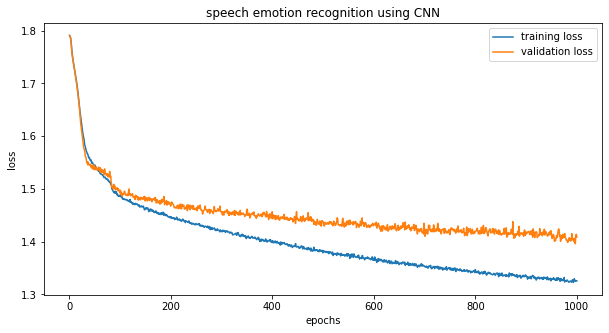

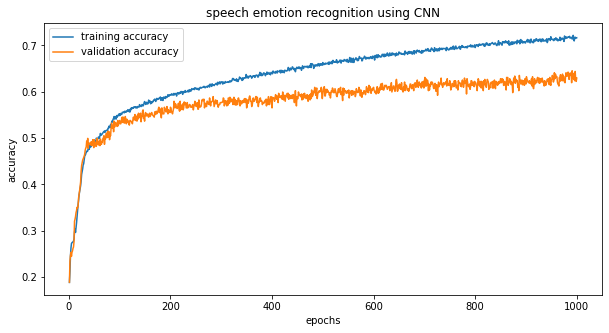

In [ ]:
# Plot for training and validation loss comparison
plt.figure(1,figsize = (10,5))
plt.plot(range(1,1001),np.array(train_losses)/batches,label='training loss')
plt.plot(range(1,1001),val_losses,label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('speech emotion recognition using CNN')
plt.legend()

# Plot for training and validation accuracy comparison
plt.figure(2,figsize = (10,5))
plt.plot(range(1,1001),np.array(train_acc)/batches,label='training accuracy')
plt.plot(range(1,1001),val_acc,label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('speech emotion recognition using CNN')
plt.legend()


In [ ]:
#Check accuracy on training and test to see how good our model

def check_accuracy(features, targets, model):
  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    
    data = features.to(device=device)
    targets = targets.to(device=device)
    data = data.float()
    scores = model(data)
    _, predictions = scores.max(1)
    #print(predictions)
    num_correct += (predictions ==targets).sum()
    num_samples += predictions.size(0)

    #print(num_correct, num_samples)
    print('accuracy is ',(float(num_correct)/float(num_samples))*100)
  model.train()


check_accuracy(test_x,test_y, model)


accuracy is  61.15127919911012
